In [175]:
import json
import torch
import numpy as np
import torch.nn as nn
from models import CVAE
from sklearn import metrics
import torch.optim as optim
import torch.nn.functional as F
from __dataset import spcamDataset
from __dataset import SubsetSampler
import seaborn as sns
from torch.utils.data import DataLoader

In [6]:
params = {
        'data_fn' : 'data/VerySmallDataset/000_train.nc',
        'input_vars' : ['TBP', 'QBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX'],
        'output_vars' : ['PRECT'],
        'norm_fn':'data/VerySmallDataset/000_norm.nc',
        'input_transform':("min", "maxrs"),
        'batch_size': 1024,
        'shuffle' : True, 
        'var_cut_off': None,
        'model_type':"regression", ## dataset related

        'inputDim' : 64,
        'hiddenDim' : [32,32], ## Symmetrical
        'outputDim' : 16, #Hidden state #VAE related


        'epochs' : 30,
        'expNumber' : "VAE_Exp01", # to be changed
        'device' : 'cuda',
        'valid_fn' : 'data/VerySmallDataset/000_valid.nc' #Misc
    }

model = CVAE(params)
optimizer = optim.Adam(model.parameters(),lr=0.00001,weight_decay=0.001)

In [5]:
model

CVAE(
  (encoder): Encoder(
    (model): Sequential(
      (hidden_0): Linear(in_features=65, out_features=32, bias=True)
      (hidden_bn_0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (hidden_activation_0): RReLU(lower=0.125, upper=0.3333333333333333)
      (hidden_1): Linear(in_features=32, out_features=32, bias=True)
      (hidden_bn_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (hidden_activation_1): RReLU(lower=0.125, upper=0.3333333333333333)
    )
    (mu): Linear(in_features=32, out_features=16, bias=True)
    (var): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (model): Sequential(
      (hidden_0): Linear(in_features=80, out_features=32, bias=True)
      (hidden_bn_0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (hidden_activation_0): RReLU(lower=0.125, upper=0.3333333333333333)
      (hidden_1): Linear(in_feature

In [58]:
### Load model
checkpoint = torch.load('./runs/VAE_model_DNN_classifier_exp_VAE_Exp04.pt')

In [59]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.cuda()
model.eval()


CVAE(
  (encoder): Encoder(
    (model): Sequential(
      (hidden_0): Linear(in_features=65, out_features=32, bias=True)
      (hidden_bn_0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (hidden_activation_0): RReLU(lower=0.125, upper=0.3333333333333333)
      (hidden_1): Linear(in_features=32, out_features=32, bias=True)
      (hidden_bn_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (hidden_activation_1): RReLU(lower=0.125, upper=0.3333333333333333)
    )
    (mu): Linear(in_features=32, out_features=16, bias=True)
    (var): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (model): Sequential(
      (hidden_0): Linear(in_features=80, out_features=32, bias=True)
      (hidden_bn_0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (hidden_activation_0): RReLU(lower=0.125, upper=0.3333333333333333)
      (hidden_1): Linear(in_feature

In [194]:
train_dataset = spcamDataset(params, phase = "train")
train_loader = DataLoader(train_dataset, sampler = SubsetSampler(train_dataset.indices))

In [257]:
for batch_idx, (data, target) in enumerate(train_loader):

    if max(target).detach().cpu().numpy()[0] > .1:
        break

In [258]:
target = target.squeeze(0).type(torch.float32).to(params['device'])
data =  data.squeeze(0).type(torch.float32).to(params['device'])

In [259]:
max(target)

tensor([0.2243], device='cuda:0')

In [260]:
z = torch.randn(1, 16).cuda()
z = torch.cat((z, data[1000].unsqueeze(0)), dim=1).cuda()

In [261]:
model.decoder(z)

tensor([[0.0033]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [253]:
def get_dis(data,target,idx):
    samples = []
    tar = target.cpu().numpy()
    
    for x in range(1000):
        z = torch.randn(1, 16).cuda()
        dp = torch.cat((z, data[idx].unsqueeze(0)), dim=1).cuda().data
        
        samples.extend(model.decoder(dp).detach().cpu().numpy())
        
    return  np.array(samples).flatten(),tar[idx][0]
    

Text(0.5, 1.0, 'Target 0')

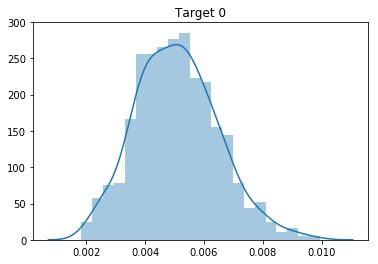

In [203]:
pts, tg = get_dis(data, target, 1)
ax = sns.distplot(pts)
ax.set_title('Target {}'.format(int(tg)))

Text(0.5, 1.0, 'Target 0.2242799997329712')

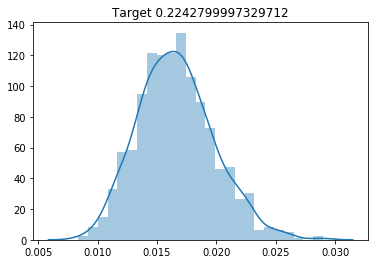

In [273]:
pts, tg = get_dis(data, target, 306)
ax = sns.distplot(pts)
ax.set_title('Target {}'.format(np.round(tg,5)))

In [272]:
np.where(target.cpu().numpy().flatten()==0.22427596)

(array([306], dtype=int64),)

In [262]:
max(target)

tensor([0.2243], device='cuda:0')

In [271]:
target.cpu().numpy().flatten()

0.22427596